In [2]:
##### Get twitter data starts here
## Get time
## In this notebook we are plotting for the United State

In [4]:
import pytz
from datetime import datetime, timedelta
import os
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import re
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np

In [2]:
### Global Variable
### Hours/days to take into consideration
### By Default we are taking into the consideration of the past 1 day
hour = 24
### The time used in Twitter is greenwich time
### By default, the real time analysis
today = datetime.now()

## To replicate the result in the manuscritp, uncomment the next line
## today = datetime(2021,9, 27, 17)

In [3]:
today

datetime.datetime(2022, 7, 13, 10, 17, 32, 458633)

In [7]:
## Get time
os.system('mkdir data')


## data collected in the range
today_str_list = []
for i in range(0, hour):
    temp = today-timedelta(hours=i)
    timestr = "*"+str(temp.year)+"-"+str(temp.month).zfill(2)+"-"+str(temp.day).zfill(2)+"_"+str(temp.hour).zfill(2)+"*"
    today_str_list.append(timestr)
today_str_list

for ele in today_str_list:
    
    cmd = 'scp flu8@keeling.earth.illinois.edu:/data/cigi/twitter-data/TwitterData2021/data/'+ele+' ./data/'
    #print(cmd)
    os.system(cmd)
## Unzip data
os.system('gzip -d ./data/*.gz')


0

In [8]:
## Read the word heat dictionary
f = open('./geo/data20000.txt','r')
content = f.read()
f.close()
dict_word = {}
content_list = content.split(",")
for i in range(0,len(content_list)):
    try:
        word = content_list[i].split(":")[0].split("'")[1]
        #print(content_list[i].split(":"))
        val = float(content_list[i].split(":")[1])
        dict_word[word] = val
    except:
        pass
    

In [9]:
## get all the getagged twitter
## National scale analysis
## This block of code will takes a long time
## We iterate through all the twitter collected for find twitter in chicago
## Get the filename
filelist = os.listdir('./data/')[1:]
filelist

## Create a dictionary for storing all Twitter with index = GEOID
heat_twitter = []

# Opening JSON file
for filename in filelist:
    filepath = "./data/"+filename
    print(filepath)
    #print(len(heat_twitter))
    f = open(filepath)
    data = json.load(f)
    
    
    ## Read the data if the centroid of the twitter point polygon lies within the boundary of the city of Chicago
    for i in range(0, len(data)):
        #if (i%50000 == 0):
        #    print(i)
        try:
            
            ##Need to deal with case when the shapefile is too big
            text = data[i]["text"]
            exact_loc = -1
            ## Case 1
            ## Twitter with exact geospatial location
            if (data[i]['geo']!=None):
                lat = data[i]['geo']['coordinates'][0]
                lon = data[i]['geo']['coordinates'][1]
                exact_loc = Point(lon, lat)
            elif (data[i]['place']!=None):
                ## Twitter with a polygon bounding box
                ## We check which county the centroid of the point lies in
                poly = data[i]['place']['bounding_box']["coordinates"][0]
                lon = [p[0] for p in poly]
                lat = [p[1] for p in poly]
                centroid = (sum(lon) / len(poly), sum(lat) / len(poly))
                exact_loc = Point(centroid)
            ## Find all the twitter with heat geotagged
            res = re.findall(r'\w+', text.lower())
            val = 0
            for word in res:
                if word in dict_word.keys():
                    val = val + dict_word[word]
            ## remove weather-irrelevant twitter
            ## if none of the word in the heat dictionary show up 
            if (val!=0):
                heat_twitter.append((exact_loc, val))
        except:
            ## no geographical location
            pass
    # Closing file
    f.close()

./data/250000-tweets-2021-09-26_19-43-23.json
./data/250000-tweets-2021-09-26_22-13-26.json
./data/250000-tweets-2021-09-27_01-25-20.json
./data/250000-tweets-2021-09-27_04-55-04.json
./data/250000-tweets-2021-09-27_07-37-52.json
./data/250000-tweets-2021-09-27_09-50-17.json
./data/250000-tweets-2021-09-27_11-54-29.json
./data/250000-tweets-2021-09-27_14-02-02.json
./data/250000-tweets-2021-09-27_16-14-54.json


In [10]:
len(heat_twitter)

43711

In [11]:
## Get US data
US = gpd.read_file("./US/county/cb_2020_us_county_20m.shp")
US

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,05,121,00069178,0500000US05121,05121,Randolph,Randolph County,AR,Arkansas,06,1688445990,10370823,"POLYGON ((-91.40492 36.49712, -91.12654 36.497..."
1,08,069,00198150,0500000US08069,08069,Larimer,Larimer County,CO,Colorado,06,6723014102,98984559,"POLYGON ((-106.19055 40.99775, -105.27714 40.9..."
2,26,105,01622995,0500000US26105,26105,Mason,Mason County,MI,Michigan,06,1281963206,1935616622,"POLYGON ((-86.51470 44.05812, -86.45807 44.099..."
3,28,153,00695797,0500000US28153,28153,Wayne,Wayne County,MS,Mississippi,06,2099745602,7255476,"POLYGON ((-88.94335 31.82456, -88.91046 31.826..."
4,38,075,01034229,0500000US38075,38075,Renville,Renville County,ND,North Dakota,06,2272050275,40658499,"POLYGON ((-102.02164 48.80711, -102.02122 48.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,16,077,00394951,0500000US16077,16077,Power,Power County,ID,Idaho,06,3635892401,99205466,"POLYGON ((-113.24348 43.11095, -113.00771 43.1..."
3217,46,085,01265789,0500000US46085,46085,Lyman,Lyman County,SD,South Dakota,06,4253498542,167300393,"POLYGON ((-100.36725 44.19462, -99.93822 44.19..."
3218,55,115,01581117,0500000US55115,55115,Shawano,Shawano County,WI,Wisconsin,06,2313441749,41883059,"POLYGON ((-89.22381 45.02925, -88.98168 45.028..."
3219,16,069,00399394,0500000US16069,16069,Nez Perce,Nez Perce County,ID,Idaho,06,2197139835,21252880,"POLYGON ((-117.03554 46.41001, -117.03665 46.4..."


In [13]:
np.save('heat_twitter_24h.npy', heat_twitter) 

/home/jovyan/.local/lib/python3.8/site-packages/numpy/lib/npyio.py:518: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/home/jovyan/.local/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [14]:
twitter_in_US = {}
## Find which county the heat twitter data falls into
## This may take a while
i = 0
for twitter in heat_twitter:
    ## Track the progress
    if (i%1000==0):
        print(i)
    #print(i)
    i = i+1
    #if (i==10):
    #    break
    try:
        exact_loc = twitter[0]
        val = twitter[1]
        for index, row in US.iterrows():
            if (row['geometry'].contains(exact_loc)):
                ## the twitter falls into the this county
                countyid = row["GEOID"]
                if (countyid in twitter_in_US.keys()):
                    twitter_in_US[countyid].append(val)
                else:
                    twitter_in_US[countyid] = [val]
                break
    except:
        pass

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000


In [130]:
## Get the number of heat-related twitter collected in each county
## get the heat exposure value for each county = average value of twitter
number_of_twitter_county = {}
heat_exposure_county = {}
for key in twitter_in_US.keys():
    number_of_twitter_county[key] = len(twitter_in_US[key])
    heat_exposure_county[key] = np.mean(twitter_in_US[key])

In [131]:
## append the lines to US dataframe
US["number_of_twitter"] = 0
US["heat_exposure"] = None

#i = 0
twitter_number = []
heat_exposure = []

for index, row in US.iterrows():
    geoid = str(row['GEOID'])
    if (geoid in heat_exposure_county.keys()):
        #print("here")
        #i = i+1
        twitter_number.append(number_of_twitter_county[geoid])
        heat_exposure.append(heat_exposure_county[geoid])
    else:
        twitter_number.append(0)
        heat_exposure.append(None)
US["number_of_twitter"] = twitter_number
US["heat_exposure"] = heat_exposure

In [132]:
## Normalize the heat exposure
mx = max(list(heat_exposure_county.values()))
mn = min(list(heat_exposure_county.values()))

normalized_heat_exposure = []

for i in range(0, len(heat_exposure)):
    if (heat_exposure[i]!=None):
        val = (heat_exposure[i]-mn)/(mx-mn)
        normalized_heat_exposure.append(val)
    else:
        normalized_heat_exposure.append(None)
US["normalized_heat_exposure"] = normalized_heat_exposure

In [133]:
US

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,number_of_twitter,heat_exposure,normalized_heat_exposure
0,05,121,00069178,0500000US05121,05121,Randolph,Randolph County,AR,Arkansas,06,1688445990,10370823,"POLYGON ((-91.40492 36.49712, -91.12654 36.497...",0,NaN,NaN
1,08,069,00198150,0500000US08069,08069,Larimer,Larimer County,CO,Colorado,06,6723014102,98984559,"POLYGON ((-106.19055 40.99775, -105.27714 40.9...",18,-0.292958,0.429290
2,26,105,01622995,0500000US26105,26105,Mason,Mason County,MI,Michigan,06,1281963206,1935616622,"POLYGON ((-86.51470 44.05812, -86.45807 44.099...",0,NaN,NaN
3,28,153,00695797,0500000US28153,28153,Wayne,Wayne County,MS,Mississippi,06,2099745602,7255476,"POLYGON ((-88.94335 31.82456, -88.91046 31.826...",0,NaN,NaN
4,38,075,01034229,0500000US38075,38075,Renville,Renville County,ND,North Dakota,06,2272050275,40658499,"POLYGON ((-102.02164 48.80711, -102.02122 48.9...",0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,16,077,00394951,0500000US16077,16077,Power,Power County,ID,Idaho,06,3635892401,99205466,"POLYGON ((-113.24348 43.11095, -113.00771 43.1...",0,NaN,NaN
3217,46,085,01265789,0500000US46085,46085,Lyman,Lyman County,SD,South Dakota,06,4253498542,167300393,"POLYGON ((-100.36725 44.19462, -99.93822 44.19...",0,NaN,NaN
3218,55,115,01581117,0500000US55115,55115,Shawano,Shawano County,WI,Wisconsin,06,2313441749,41883059,"POLYGON ((-89.22381 45.02925, -88.98168 45.028...",1,-0.145698,0.471636
3219,16,069,00399394,0500000US16069,16069,Nez Perce,Nez Perce County,ID,Idaho,06,2197139835,21252880,"POLYGON ((-117.03554 46.41001, -117.03665 46.4...",0,NaN,NaN


In [125]:
## Some basic analysis
## Get the total number of county with twitter data recorded
print("There are "+ str(len(twitter_in_US.keys())) +" counties have twitter related twitter recorded")
total_twitter_in_US = 0
for key in twitter_in_US.keys():
    #print (key)
    total_twitter_in_US = total_twitter_in_US + len(twitter_in_US[key])
print("There are "+ str(total_twitter_in_US) +" Twitter in US" )
ave_tw = total_twitter_in_US/US.shape[0]
print("On average, there are "+str(ave_tw)+" twitter receieved from each county")
## Find the county with the most amoutn of heat relatd twitter
most_twitter = US[US["number_of_twitter"] == max(list(US["number_of_twitter"]))]
print(list(most_twitter["NAME"])[0]+" county has the most amount of Twitter recorded, which is "+ str(list(most_twitter["number_of_twitter"])[0]))
#str(list(most_twitter["number_of_twitter"])[0])

There are 1230 counties have twitter related twitter recorded
There are 19995 Twitter in US
On average, there are 6.207699472213598 twitter receieved from each county
Los Angeles county has the most amount of Twitter recorded, which is 1090


In [126]:
## Places with the least heat exposure
US[US["normalized_heat_exposure"] == 0]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,number_of_twitter,heat_exposure,normalized_heat_exposure
2140,23,007,00581289,0500000US23007,23007,Franklin,Franklin County,ME,Maine,06,4395220895,121290428,"POLYGON ((-70.82979 45.28694, -70.80861 45.311...",1,-1.785821,0.0


In [127]:
## Places with most heat exposure
US[US["normalized_heat_exposure"] == 1]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,number_of_twitter,heat_exposure,normalized_heat_exposure
3037,22,007,00558414,0500000US22007,22007,Assumption,Assumption Parish,LA,Louisiana,15,891009958,67104891,"POLYGON ((-91.25939 30.00020, -91.22423 30.025...",1,1.691699,1.0


In [136]:
## Generate a quantile map
## For the number twitter as most of the county don't have heat related twitter
quantile = []
curr = list(US["number_of_twitter"])
for i in curr:
    if (i==0):
        quantile.append(None)
    else:
        quantile.append(i)
US["number_of_twitter_for_quantile"] = quantile

<AxesSubplot:>

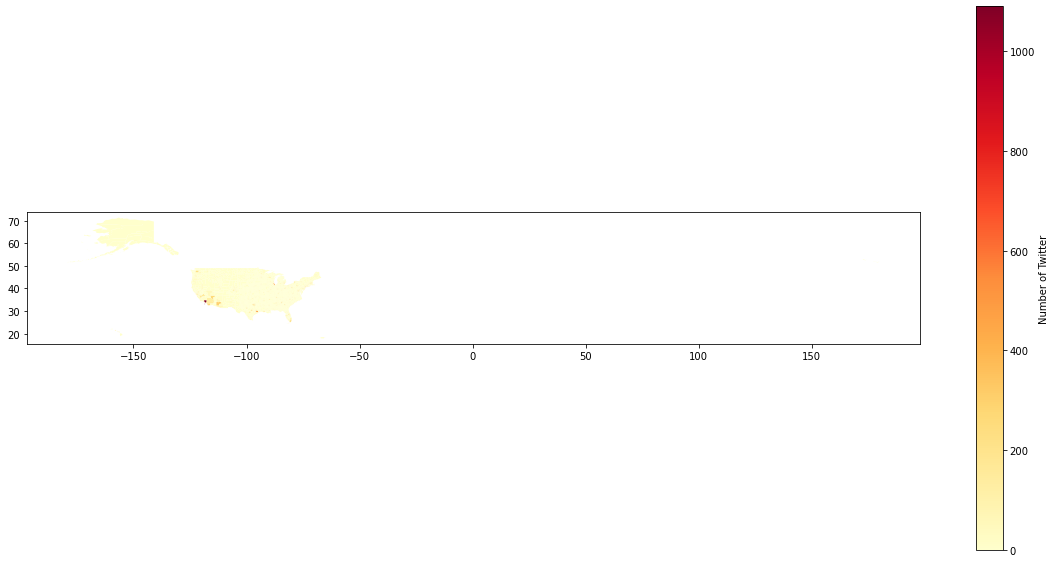

In [143]:
## Creating Choropleth Map with geopandas 
## First create map for with the number of Twitter
## Actual Value of the the number of Twitter
US.plot(column = 'number_of_twitter', #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd',
                      legend_kwds = {'label': "Number of Twitter"}) #Name the legend

<AxesSubplot:>

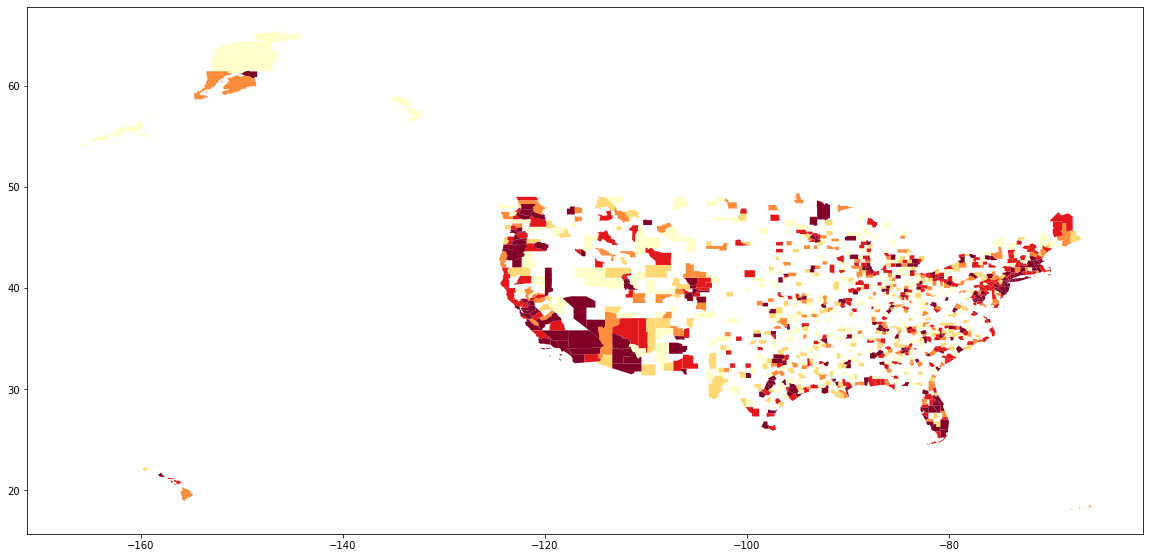

In [144]:
## Quantile map for the amount of Twitter
US.plot(column = 'number_of_twitter_for_quantile', #Assign numerical data column
                      figsize = [20,10],
                      cmap = 'YlOrRd',
                      scheme='QUANTILES',
                      legend_kwds = {'label': "Number of Twitter"}) #Name the legend

<AxesSubplot:>

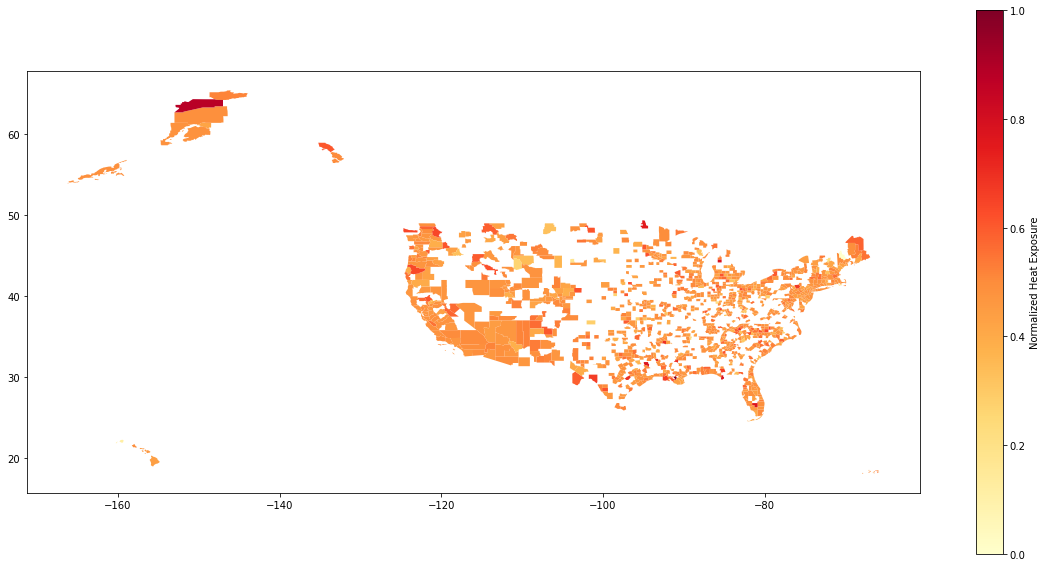

In [145]:
## Creating Choropleth Map with geopandas 
## Actual map for the Heat Exposure
US.plot(column = 'normalized_heat_exposure', #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd',
                      legend_kwds = {'label': "Normalized Heat Exposure"}) #Name the legend

<AxesSubplot:>

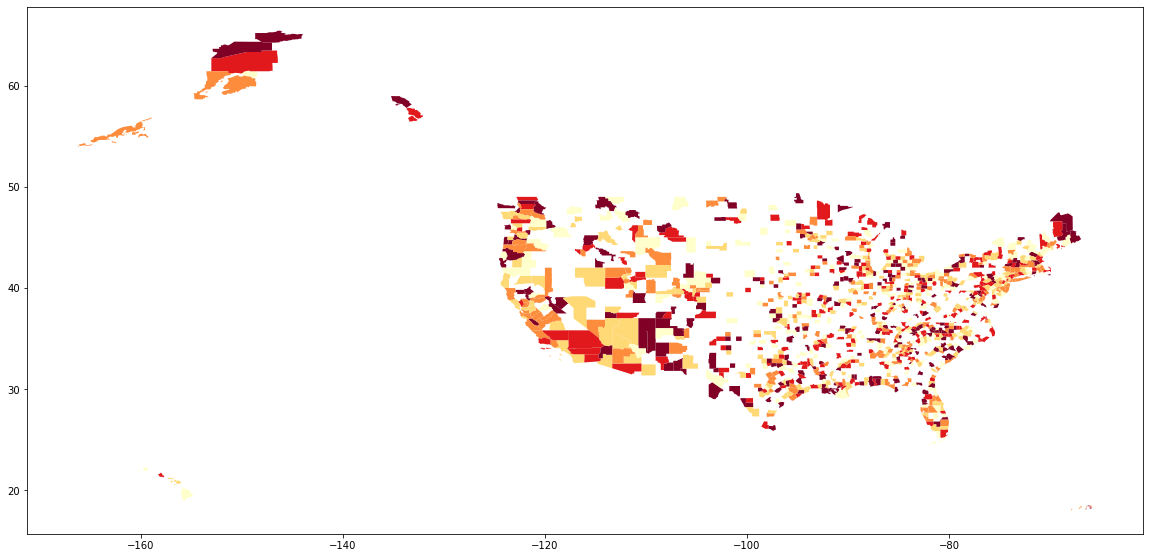

In [146]:
## Creating Choropleth Map with geopandas 
## Quantile map for the Heat Exposure
US.plot(column = 'normalized_heat_exposure', #Assign numerical data column
                      figsize = [20,10],
                      cmap = 'YlOrRd',
                      scheme='QUANTILES',
                      legend_kwds = {'label': "Normalized Heat Exposure"}) #Name the legend

In [90]:
US

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,number_of_twitter,heat_exposure,normalized_heat_exposure
0,05,121,00069178,0500000US05121,05121,Randolph,Randolph County,AR,Arkansas,06,1688445990,10370823,"POLYGON ((-91.40492 36.49712, -91.12654 36.497...",0,NaN,NaN
1,08,069,00198150,0500000US08069,08069,Larimer,Larimer County,CO,Colorado,06,6723014102,98984559,"POLYGON ((-106.19055 40.99775, -105.27714 40.9...",18,-0.292958,0.429290
2,26,105,01622995,0500000US26105,26105,Mason,Mason County,MI,Michigan,06,1281963206,1935616622,"POLYGON ((-86.51470 44.05812, -86.45807 44.099...",0,NaN,NaN
3,28,153,00695797,0500000US28153,28153,Wayne,Wayne County,MS,Mississippi,06,2099745602,7255476,"POLYGON ((-88.94335 31.82456, -88.91046 31.826...",0,NaN,NaN
4,38,075,01034229,0500000US38075,38075,Renville,Renville County,ND,North Dakota,06,2272050275,40658499,"POLYGON ((-102.02164 48.80711, -102.02122 48.9...",0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,16,077,00394951,0500000US16077,16077,Power,Power County,ID,Idaho,06,3635892401,99205466,"POLYGON ((-113.24348 43.11095, -113.00771 43.1...",0,NaN,NaN
3217,46,085,01265789,0500000US46085,46085,Lyman,Lyman County,SD,South Dakota,06,4253498542,167300393,"POLYGON ((-100.36725 44.19462, -99.93822 44.19...",0,NaN,NaN
3218,55,115,01581117,0500000US55115,55115,Shawano,Shawano County,WI,Wisconsin,06,2313441749,41883059,"POLYGON ((-89.22381 45.02925, -88.98168 45.028...",1,-0.145698,0.471636
3219,16,069,00399394,0500000US16069,16069,Nez Perce,Nez Perce County,ID,Idaho,06,2197139835,21252880,"POLYGON ((-117.03554 46.41001, -117.03665 46.4...",0,NaN,NaN


In [147]:
### write the dataframe out as geojson
with open('./output/national_heat_exposure.json', 'w') as f:
        f.write(US.to_json())

In [149]:
## remove all data
## Uncomment the next line if you want to remove all the Twitter data
os.system('rm -rf data')

256

In [148]:
## Finally, if you want to conduct additional analysis based on the reulst
## Please Run
## 1. data_collection.ipny to collect socioeconomic data
## 3. analysis.ipny to conduct further analysis